### **Loading Libraries**

In [1]:
import torch
import torchvision
from torch.nn import functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import numpy as np
import time

import matplotlib.pyplot as plt

### **Variational Autoencoder Class**

In [2]:
class VariationalAutoencoders(nn.Module):
    def __init__(self, n_channel, z_dim):
        super().__init__()
        self.encoder_conv1 = nn.Conv2d(1, n_channel, kernel_size=3, stride=1, padding=1)
        self.encoder_conv2 = nn.Conv2d(n_channel, n_channel*2, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(n_channel*2, n_channel*2, kernel_size=3, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(n_channel*2, n_channel*2, kernel_size=3, stride=1, padding=1)
        self.mu = nn.Linear(3136,z_dim)
        self.log_var = nn.Linear(3136,z_dim)
        self.fc1 = nn.Linear(z_dim, 3136)
        self.decoder_conv1 = nn.ConvTranspose2d(n_channel*2,n_channel*2, kernel_size=3, stride=1, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(n_channel*2, n_channel*2, kernel_size=3, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(n_channel*2, n_channel, kernel_size=3, stride=2, padding=1)
        self.decoder_conv4 = nn.ConvTranspose2d(n_channel, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, encoder_input):
        # Encoder
        x = F.leaky_relu(self.encoder_conv1(encoder_input))
        upsample1_size = x.size()
        x = F.leaky_relu(self.encoder_conv2(x))
        upsample2_size = x.size()
        x = F.leaky_relu(self.encoder_conv3(x))
        x = F.leaky_relu(self.encoder_conv4(x))
        x = x.view(-1, 3136)
        mu = self.mu(x)
        log_var = self.log_var(x)
        epsilon = torch.randn(mu.size())
        encoder_output = mu + torch.exp(log_var / 2) * epsilon

        # Decoder
        x = F.relu(self.fc1(encoder_output))
        x = x.view(-1,64,7,7)
        #x = x.reshape((None,64,7,7))
        x = F.leaky_relu(self.decoder_conv1(x))
        x = F.leaky_relu(self.decoder_conv2(x, output_size=upsample2_size))
        x = F.leaky_relu(self.decoder_conv3(x, output_size=upsample1_size))
        x = F.leaky_relu(self.decoder_conv4(x))
        decoder_output = F.sigmoid(x)
        
        return decoder_output, mu, log_var

In [3]:
device = 'cuda'
model = VariationalAutoencoders(n_channel=32, z_dim=2)#.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE + KLD).to('cuda')

In [4]:
model

VariationalAutoencoders(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mu): Linear(in_features=3136, out_features=2, bias=True)
  (log_var): Linear(in_features=3136, out_features=2, bias=True)
  (fc1): Linear(in_features=2, out_features=3136, bias=True)
  (decoder_conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [5]:
bs = 256
# MNIST Dataset
train_dataset = datasets.MNIST(root='/home/mayur/Desktop/Pytorch/data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/home/mayur/Desktop/Pytorch/data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [6]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        start = time.time()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        end = time.time()
        print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(train_loader.dataset):.4f}, Time: {end-start} Seconds')
    return model

In [7]:
trained_model = train(50)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


====> Epoch: 1 Average loss: 251.9990, Time: 97.27359700202942 Seconds
====> Epoch: 2 Average loss: 176.0899, Time: 98.34475874900818 Seconds
====> Epoch: 3 Average loss: 169.0839, Time: 99.14751243591309 Seconds
====> Epoch: 4 Average loss: 165.2882, Time: 99.41934633255005 Seconds
====> Epoch: 5 Average loss: 162.4543, Time: 98.12184882164001 Seconds
====> Epoch: 6 Average loss: 159.8843, Time: 98.7273461818695 Seconds
====> Epoch: 7 Average loss: 157.7706, Time: 96.23341202735901 Seconds
====> Epoch: 8 Average loss: 156.0465, Time: 94.0798168182373 Seconds
====> Epoch: 9 Average loss: 154.7233, Time: 96.2291898727417 Seconds
====> Epoch: 10 Average loss: 153.6679, Time: 93.32412219047546 Seconds
====> Epoch: 11 Average loss: 152.6988, Time: 93.70657658576965 Seconds
====> Epoch: 12 Average loss: 151.8254, Time: 92.96965098381042 Seconds
====> Epoch: 13 Average loss: 151.1754, Time: 93.11532211303711 Seconds
====> Epoch: 14 Average loss: 150.6054, Time: 93.08154153823853 Seconds
====

### **Saving the Model**

In [8]:
PATH = './vae.pth'
torch.save(trained_model.state_dict(), PATH)

### **Loading Pretrained Model for Evaluation**

In [9]:
model = VariationalAutoencoders(n_channel=32, z_dim=2)
model.load_state_dict(torch.load(PATH))
model.eval()

VariationalAutoencoders(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mu): Linear(in_features=3136, out_features=2, bias=True)
  (log_var): Linear(in_features=3136, out_features=2, bias=True)
  (fc1): Linear(in_features=2, out_features=3136, bias=True)
  (decoder_conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### **Checking Model's Output on Trained Model on Test dataset**

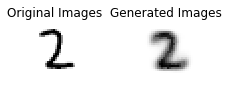

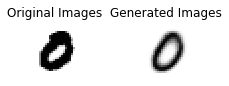

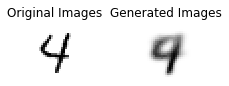

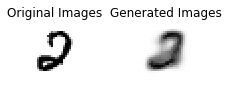

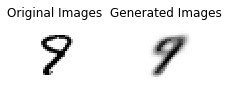

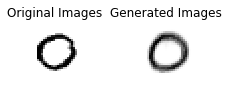

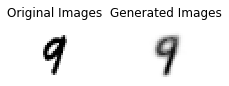

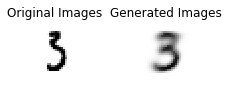

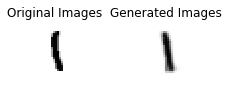

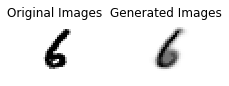

In [15]:
example_idx = np.random.choice(range(len(test_dataset)), 10)

#z_points = vae.encoder.predict(example_images)
for image in example_idx:
    reconst_images, _, _ = model(test_dataset[image][0].unsqueeze(1))
    fig = plt.figure(figsize=(3, 3))
    fig.subplots_adjust(hspace=1.0, wspace=1.0)
    img = test_dataset[image][0].squeeze()
    sub = fig.add_subplot(1, 2, 1)
    sub.axis('off')
    plt.title("Original Images")
    sub.imshow(img, cmap='gray_r')
    img = reconst_images.squeeze().detach().numpy()
    sub = fig.add_subplot(1, 2, 2)
    sub.axis('off')
    plt.title("Generated Images")
    sub.imshow(img, cmap='gray_r')